### 3.2.4 NiN块 网络中的网络
`LeNet`、`AlexNet`和`VGG`都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取**空间结构特征**,然后通过**全连接层**对特征的表征进行处理。AlexNet和VGG对LeNet的改进主要在于如何构造一个更深的网络。
然而，如果使用了全连接层，可能会**完全放弃表征**的空间结构，会带来*过拟合*，内存也要求很大。
* 卷积层需要较少的参数

$$
c_i \times c_o \times k^2
$$

* 但卷积后的第一个全连接层的参数：
  * LeNet
    * 16x5x5x120= 48k
  * AlexNet
    * 256x5x5x4096 = 26M
  * VGG
    * 512x7x7x4096= 102M

**NiN的设计思想**: 完全不要全连接层, 使用卷积层来进行替代。在每个像素的通道上分别使用多层感知机。 实际上NiN的使用并不算广泛，但其提出了新的概念。


![](https://zh-v2.d2l.ai/_images/nin.svg)

* 1 $\times$ 1的卷积层（**等价于一个全连接层**）
* 交替使用**NiN块**和步幅为2的**最大池化层**（高宽减半）
  * 逐步减小高宽和增大通道数
* 最后使用全局平均池化层得到输出
  * 其（最后一层）输入通道数是类别数（每个通道拿出一个值）

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

#### NiN块代码实现

In [3]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

#### NiN模型代码实现

In [4]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),  # 10个类别
    nn.AdaptiveAvgPool2d((1, 1)),  # 全局平均池化层，池化后的每个通道上的大小是一个1x1
    nn.Flatten()  # 将四维的输出转成二维的输出，其形状为(批量大小, 10)
)

In [5]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


#### 训练

loss 0.349, train acc 0.869, test acc 0.863
379.2 examples/sec on cuda:0


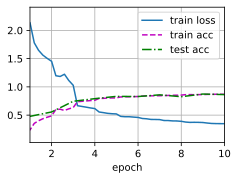

In [6]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())